In [6]:
import keras
from keras import layers
import numpy as np

latent_dim = 100
class_num = 10
height = 28
width = 28
channels = 1
img_shape = (height, width, channels)

adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)

#初期化している
init = keras.initializers.RandomNormal(stddev=0.02)

In [7]:
#生成ネットワーク
noise = keras.Input(shape=(latent_dim,))
gen_label = keras.Input(shape=(1,), dtype='float32')
#ラベル情報をembeddingに埋め込む。
label_embedding = layers.Embedding(class_num, latent_dim, input_length=1)(gen_label)
label_embedding = layers.Flatten()(label_embedding)
joined_embedding = layers.Multiply()([noise, label_embedding])

#潜在変数を7x7 128-channels 特徴マップへ変換
x = layers.Dense(128 * 7 * 7,kernel_initializer=init)(joined_embedding)
#この実装では生成ネットワークの活性化関数にLeakyReLUを用いるが
#代わりに以下のBatchNormalization＋LeRUを使う場合もある
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((7, 7, 128))(x)

#7x7 128-channelsを14x14 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)

#14x14 64-channelsを28x28 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)


#28x28 64-channelsを28x28 1-channelsの特徴マップへ変換
#最後の出力の活性化関数はtanhを使う
x = layers.Conv2D(channels, 5, activation='tanh', padding='same')(x)
generator = keras.models.Model([noise, gen_label], x)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       1000        input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 100)          0           embedding_3[0][0]                
____________________________________________________________________________________________

In [9]:
#識別ネットワーク
disc_input = keras.Input(shape=(img_shape))
disc_label = keras.Input(shape=(1,), dtype='float32')
disc_label_embedding = layers.Embedding(class_num, np.prod(img_shape), input_length=1)(disc_label)
disc_label_embedding = layers.Flatten()(disc_label_embedding)
disc_label_embedding = layers.Reshape(img_shape)(disc_label_embedding)
discriminator_input = layers.Concatenate(axis=-1)([disc_input, disc_label_embedding])
#28×28×2
x = layers.Conv2D(64, 5, strides=2,padding='same',kernel_initializer=init)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model([disc_input, disc_label], x)
discriminator.summary()


discriminator_optimizer  = adam
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 784)       7840        input_10[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 784)          0           embedding_5[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
____________________________________________________________________________________________

In [13]:
#敵対的ネットワーク

#識別ネットワークの学習を止めて
discriminator.trainable = False
#生成ネットワークの学習をする
gan_input = keras.Input(shape=(latent_dim,))
gan_input_label = keras.Input(shape=(1,), dtype='float32')
gan_disc_label = keras.Input(shape=(1,), dtype='float32')                      
gan_output = discriminator([generator([gan_input, gan_input_label]), gan_disc_label])
gan = keras.models.Model([gan_input, gan_input_label, gan_disc_label], gan_output)

gan_optimizer = adam 
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [15]:
import os
from keras.preprocessing import image
from keras.datasets import mnist
from tqdm import tqdm
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

# MNIST dataのロード
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#生成者の出力をtanhとしたので
#各ピクセルが[-1,1]の値を取るように正規化し、テンソル化
x_train = (x_train.astype('float32')-127.5)/ 127.5
x_train = x_train.reshape(x_train.shape + (1,))
x_test = (x_test.astype('float32')-127.5)/ 127.5
x_test = x_test.reshape(x_test.shape + (1,))

#DCGAN論文で使われているバッチ数を使う
batch_size = 128

epochs=10
batchSize=batch_size
batchCount = x_train.shape[0] / batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

# 学習のループ
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15) 

    for i in range(int(batchCount)):
        print("\r{0}% [{1}]".format(int(i/(batchCount-1)*100), "*" * int((i+1)/batchCount*50)), end="")
      
        #識別器の訓練
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        train_imgs, train_labels = x_train[idx], y_train[idx]

        z = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict([z, train_labels])

        combined_images = np.concatenate([gen_imgs, train_imgs])
        combined_labels = np.concatenate([train_labels, train_labels])
        #np.concatenate([a,b])はa, bをaxis=0方向に結合する。

        # 観測データ(0)と生成データ(1)を識別するラベルをつくる
        tf_labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
        
        # ランダムなノイズを加える
        # ラベルを1ではなく0.7-1.2, 0を0-0.3のようなソフトラベルにすることもある
        #labels += 0.05 * np.random.random(labels.shape)
        tf_labels *= 0.9


        #識別ネットワークの学習
        ##keras.models.Model.train_on_batchでバッチごとにパラメータ更新を行う。
        d_loss = discriminator.train_on_batch([combined_images, combined_labels], tf_labels)

        #潜在空間からサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        random_gen_labels = np.random.randint(0, 9, (batch_size, 1))

        # すべてリアルなデータだと騙すためのラベル(y=0)を生成
        misleading_targets = np.zeros((batch_size, 1))

        # 生成ネットワークの学習
        ##GANに入れてdicriminatorを通って出てくるのでoutputは0~1の数値が出てくる。
        ##generatorとしてはdiscriminatorがすべて1として返すのが理想なので、discriminatorのoutputと1との差をlossとして学習する。
        # min -y*log(D(G(z)))
        a_loss = gan.train_on_batch([random_latent_vectors, random_gen_labels, random_gen_labels], misleading_targets)
        if i==int(batchCount)-1 :
            print("\n") 
            print('discriminator loss: %s' % (d_loss))
            print('adversarial loss  : %s' % (a_loss))

Epochs: 10
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------
0% []

c:\anaconda3\envs\py37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\anaconda3\envs\py37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\anaconda3\envs\py37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0% []

c:\anaconda3\envs\py37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


FailedPreconditionError:  Error while reading resource variable _AnonymousVar55 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/_AnonymousVar55/class tensorflow::Var does not exist.
	 [[node mul_43/ReadVariableOp (defined at c:\anaconda3\envs\py37\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_2942]

Function call stack:
keras_scratch_graph


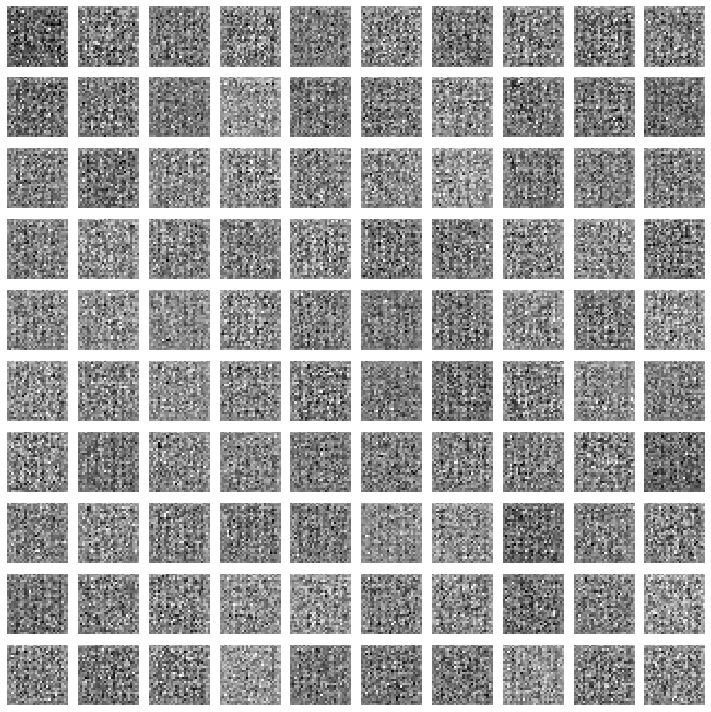

In [14]:
import matplotlib.pyplot as plt
#表示するサンプル数
examples=100
#潜在空間からサンプリング
ex_noise = np.random.normal(0, 1, size=[examples, latent_dim])
ex_labels = np.random.randint(0, 9, (examples, 1))
#画像を生成
generatedImages = generator.predict([ex_noise, ex_labels])
#画像を描画
dim=(10, 10)
plt.figure(figsize=(10, 10))
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    subplot_title = ex_labels[i]
    plt.imshow(generatedImages[i].reshape(height, width), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.tight_layout()
#plt.savefig('./dcgan_generated_image_epoch_%d.png' % epoch)